In [0]:
# Import All Nesessary Libraries
import os, random, gc, math, time
import numpy as np
import pandas as pd

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras_preprocessing.image
import keras.backend as k
from keras.applications import VGG16, VGG19
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization, Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, LeakyReLU
from keras.layers import Input, AvgPool2D, Conv2D
from keras.layers import multiply, concatenate, Lambda, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight


# Configuration
%matplotlib inline

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Specifying the Training Parameters

is_pretrained = True
keep_training = True # Adam -> SGD
batch_size = 39
width = 150
height = 150
learning_rate = 1e-4
batch_size = 64
epochs = 10

In [0]:

def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

In [120]:

# Defining Paths

target_size = (height, width)
class_mode = 'categorical'
training_dir = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/train'
testing_dir = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/test'
validation_dir = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/val'
proj_dir = 'temp'
# Creating Directories to Store Models
!mkdir temp/
!mkdir temp/models
!mkdir images

mkdir: cannot create directory ‘temp/’: File exists
mkdir: cannot create directory ‘temp/models’: File exists
mkdir: cannot create directory ‘images’: File exists


In [121]:
# TrainSet Preparation
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=target_size,
                                                    interpolation='lanczos',
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 2570 images belonging to 2 classes.


In [122]:
# TestSet Preparation
test_datagen = ImageDataGenerator(
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(testing_dir,
                                                  target_size=target_size,
                                                  interpolation='lanczos',
                                                  class_mode=class_mode,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 624 images belonging to 2 classes.


In [123]:

def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[0.95824012 1.0455655 ]


In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

# tr_normal = get_image_set('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/train/NORMAL')
# tr_pneumonia = get_image_set('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/train/PNEUMONIA')

# te_normal = get_image_set('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/test/NORMAL')
# te_pneumonia = get_image_set('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/test/PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

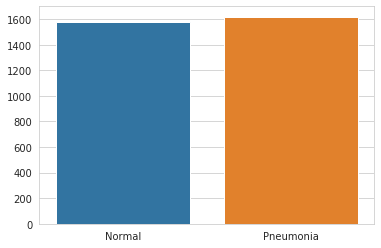

In [125]:

# Plotting the count of Patient Types
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

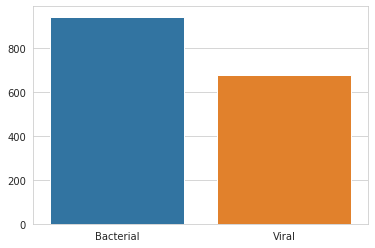

In [126]:

# Plotting the type of Dieseases
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

In [0]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

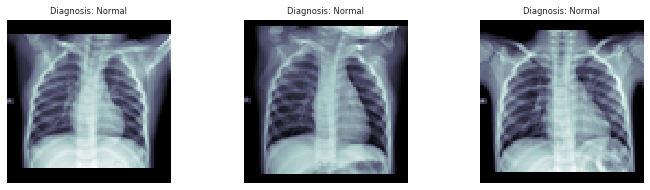

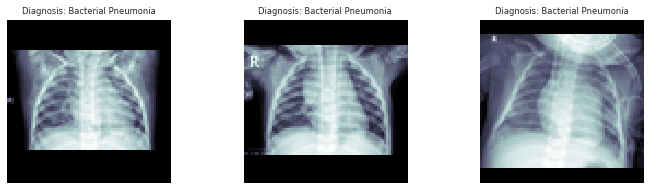

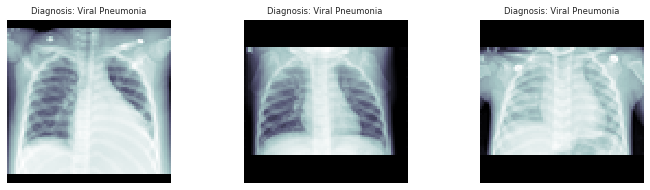

In [128]:

# Plotting Sample Images
plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

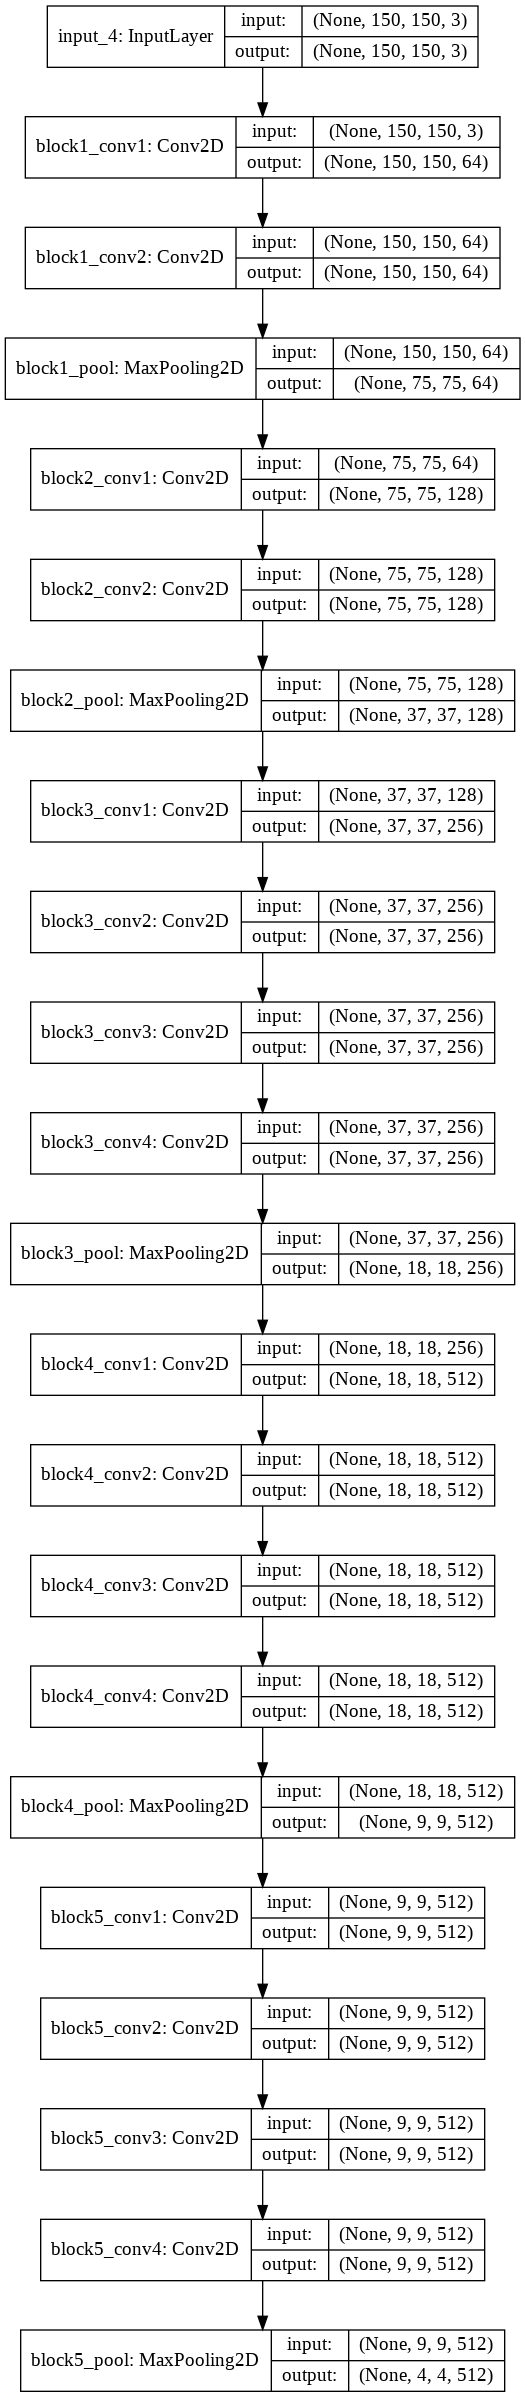

In [129]:

#BASE MODEL 1
common_input = Input(shape=(height, width, 3))

# create the base pre-trained model
base_model_1 = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(height, width, 3))

base_model_1.summary()
plot_model(base_model_1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [0]:
# ASdding Custom Layers to the Pred-Build Network 
x1 = base_model_1.output
x1 = Dropout(0.5)(x1)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = BatchNormalization()(x1)
predictions = Dense(2, activation='sigmoid')(x1)

for layer in base_model_1.layers:
    layer.trainable = False

  
model_1 = Model(inputs=base_model_1.input, outputs=predictions)
model_1.compile(optimizer=Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'MODEL_ACC-{val_acc:.2f}-MODEL_LOSS-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

# Early Stopping Parameters
checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_weights_only=True,
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

In [133]:

# Fitting the model to the Data
hist = model_1.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=20,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

Epoch 1/20
41/41 [==============================] - 113s 3s/step - loss: 0.4073 - acc: 0.8399 - val_loss: 0.3811 - val_acc: 0.8558
Epoch 2/20
41/41 [==============================] - 113s 3s/step - loss: 0.3483 - acc: 0.8672 - val_loss: 0.3654 - val_acc: 0.8670
Epoch 3/20
41/41 [==============================] - 113s 3s/step - loss: 0.3348 - acc: 0.8668 - val_loss: 0.3540 - val_acc: 0.8702
Epoch 4/20
41/41 [==============================] - 113s 3s/step - loss: 0.3178 - acc: 0.8745 - val_loss: 0.3493 - val_acc: 0.8718
Epoch 5/20
41/41 [==============================] - 114s 3s/step - loss: 0.3043 - acc: 0.8766 - val_loss: 0.3499 - val_acc: 0.8734
Epoch 6/20
41/41 [==============================] - 112s 3s/step - loss: 0.2909 - acc: 0.8793 - val_loss: 0.3532 - val_acc: 0.8622
Epoch 7/20
41/41 [==============================] - 112s 3s/step - loss: 0.2885 - acc: 0.8811 - val_loss: 0.3476 - val_acc: 0.8622
Epoch 8/20
41/41 [==============================] - 113s 3s/step - loss: 0.2636 - a

In [0]:
model_1.save('Pneumonia using VGG16 and VGG 19.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

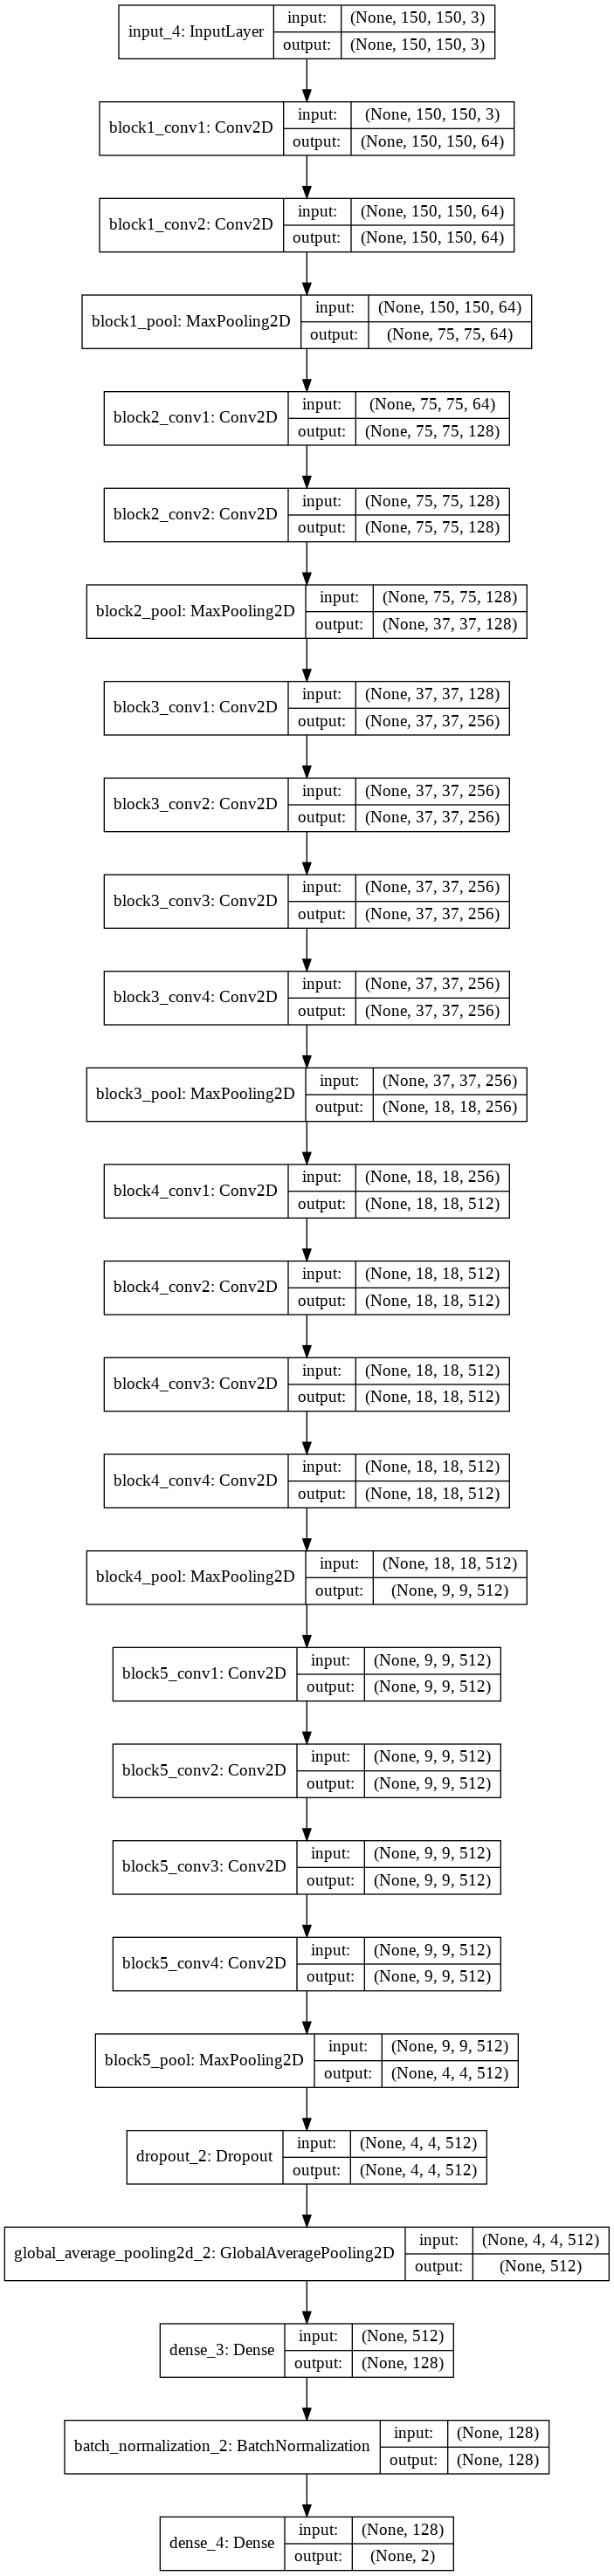

In [135]:
model_1.summary()
plot_model(model_1, to_file='model_1_architecture.png', show_shapes=True, show_layer_names=True)


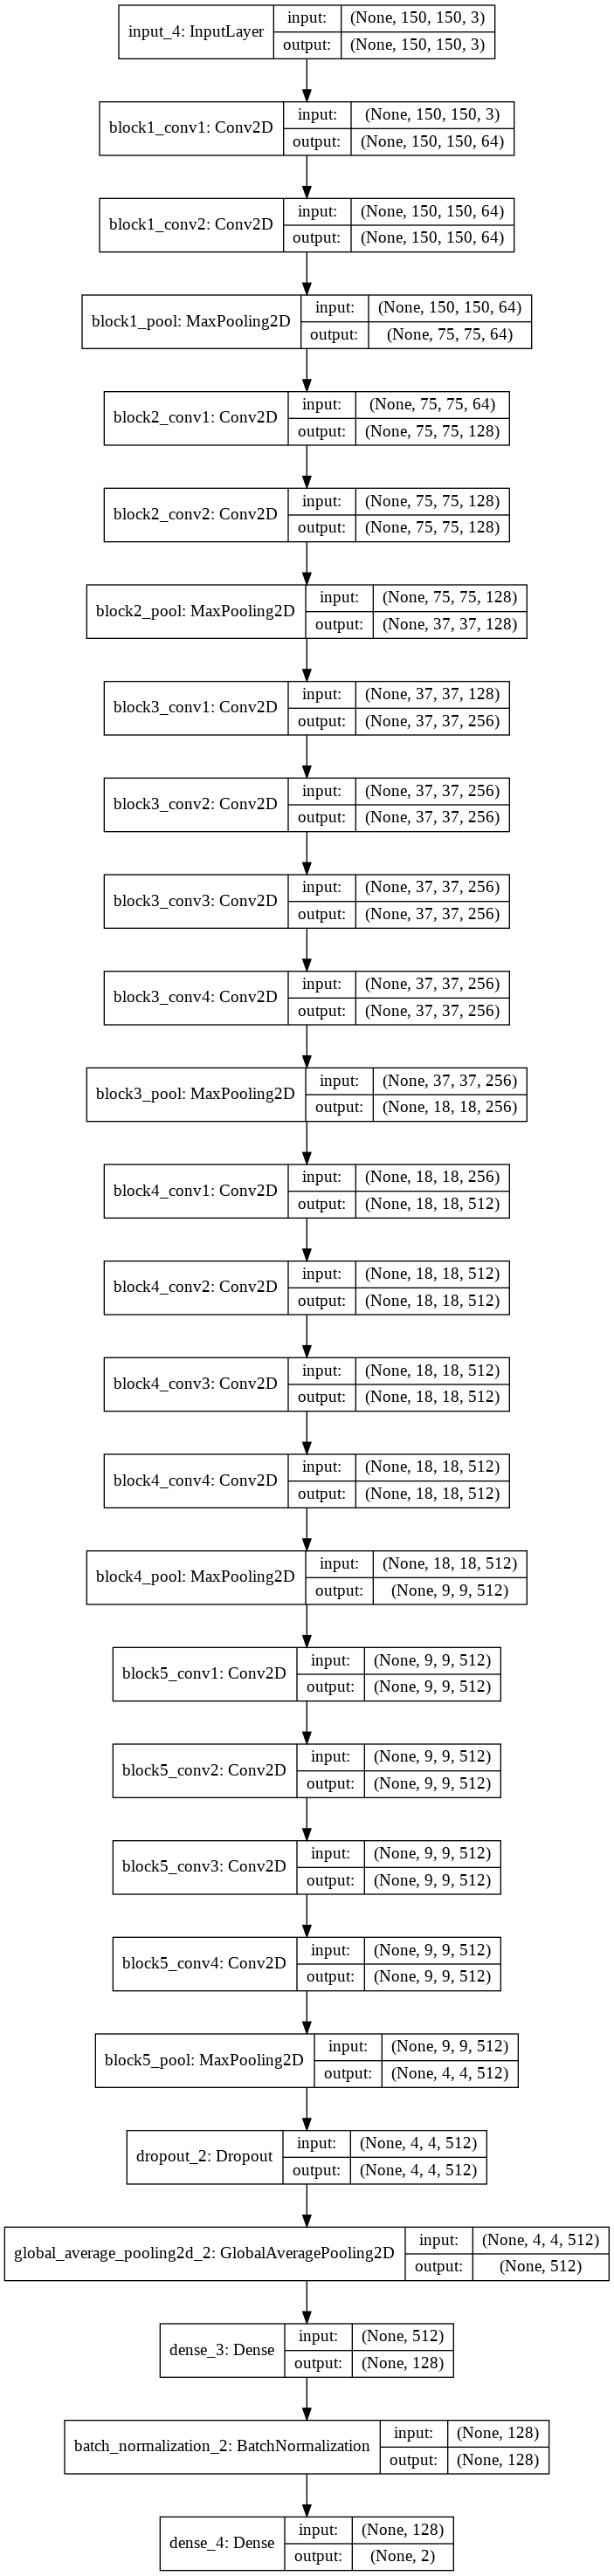

In [136]:
# Saving Model Graph

plot_model(model_1, to_file='images/Generator_model_plot.png', show_shapes=True, show_layer_names=True)

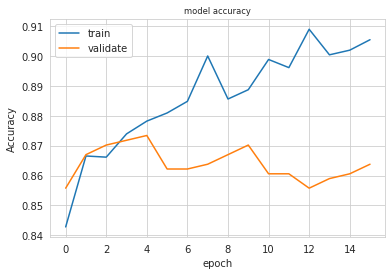

In [137]:
# Training Accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [138]:
# Diffrent Evaluation Metrics
vl_score = model_1.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.82      0.84      0.83       234
   Pneumonia       0.90      0.89      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.87      0.87      0.87       624

AUC:  0.8670940170940171


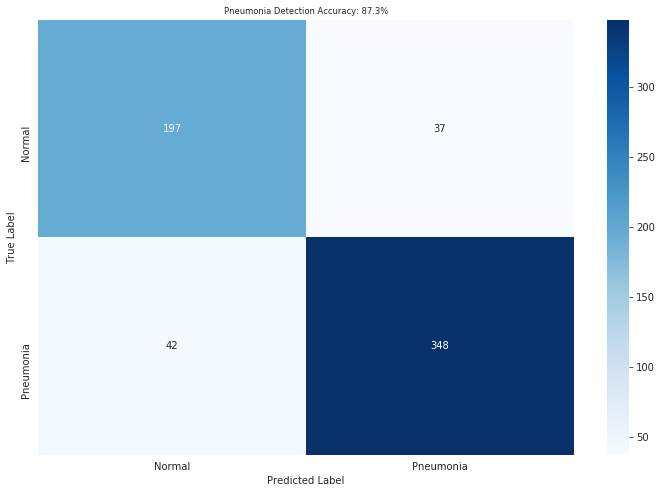

In [139]:
# plotting Confussion Accuracy
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [140]:

y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model_1.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0

In [141]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batches, y_true_batches = test_generator[batch_no] 
y_true_batches = y_true_batches.argmax(axis=-1)

y_pred_batches = model_1.predict(y_img_batch)
y_pred_batches = y_pred_batches.argmax(axis=-1)


sizeofbatch = len(y_true_batches)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batches)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batches==y_pred_batches)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 3
-----------------------------------
Batch Size              : 48
-----------------------------------
Accuracy                : 0.00%
-----------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [0]:
# # Creates directory, if directory exists removes if remove parameter is set to True 
# def create_directory(directory_path, remove=False):
#     if remove and os.path.exists(directory_path):
#         try:
#             shutil.rmtree(directory_path)
#             os.mkdir(directory_path)
#         except:
#             print("Could not remove directory : ", directory_path)
#             return False
#     else:
#         try:
#             os.mkdir(directory_path)
#         except:
#             print("Could not create directory: ", directory_path)
#             return False
        
#     return True

# # Removes directory, if directory exists 
# def remove_directory(directory_path):
#     if os.path.exists(directory_path):
#         try:
#             shutil.rmtree(directory_path)
#         except:
#             print("Could not remove directory : ", directory_path)
#             return False
        
#     return True

# def clear_directory(directory_path):
#     dirs_files = os.listdir(directory_path)
    
#     for item in dirs_files:
# #         item_path = os.path.join(directory_path, item)
#         item_path = directory_path+ item
        
#         try:
#             if os.path.isfile(item_path):
#                 os.unlink(item_path)
#             elif os.path.isdir(item_path): 
#                 shutil.rmtree(item_path)
#         except Exception as e:
#             print(e)
            
#     return True


# def remove_empty_folders(path, removeRoot=True):
#     if not os.path.isdir(path):
#         return
    
#     # remove empty subfolders
#     files = os.listdir(path)
    
#     if len(files):
#         for f in files:
#             fullpath = os.path.join(path, f)
            
#             if os.path.isdir(fullpath):
#                 remove_empty_folders(fullpath)

#     # if folder empty, delete it
#     files = os.listdir(path)
    
#     if len(files) == 0 and removeRoot:
#         print("Removing empty folder:", path)
#         os.rmdir(path)
        
        
# def dir_file_count(directory):
#     return sum([len(files) for r, d, files in os.walk(directory)])

In [0]:
# #data visualizations

# def get_reset_subplot_params(nrows, ncols, dpi):
#     subplot_params = {}
#     subplot_params["nrows"] = nrows
#     subplot_params["ncols"] = ncols

#     subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
#     subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
#     subplot_params["dpi"] = dpi
#     subplot_params["facecolor"] = 'w'
#     subplot_params["edgecolor"] = 'k'
#     subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
#     subplot_params["axes.titlesize"] = 'small'
#     subplot_params["hspace"] = 0.5
#     subplot_params["wspace"] = 0.3
    
#     return subplot_params

# def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
#     plot_params = {}
    
#     plot_params["figsize"] = figsize
    
#     plot_params["title"] = title
    
#     plot_params["xlabel"] = xlabel
#     plot_params["ylabel"] = ylabel
    
#     plot_params["legends"] = legends 
    
#     plot_params["title_fontsize"] = title_fontsize
#     plot_params["axes.titlesize"] = "small"
#     plot_params["label_fontsize"] = label_fontsize
    
#     plot_params["image_file_name"] = image_file_name
#     plot_params["save"] = save
#     plot_params["update_image"] = update_image
    
#     plot_params["subplot"] = None
#     return plot_params

In [0]:
# # count number of files in each subdirectory of a directory
# def subdirectory_file_count(master_directory):
#     subdirectories = os.listdir(master_directory)
#     subdirectory_count = len(subdirectories)

#     subdirectory_names = []
#     subdirectory_file_counts = []

#     for subdirectory in subdirectories:
#         current_directory = os.path.join(master_directory, subdirectory)
#         file_count = len(os.listdir(current_directory))
#         subdirectory_names.append(subdirectory)
#         subdirectory_file_counts.append(file_count)
    
#     return subdirectory_names, subdirectory_file_counts
         
    

# # show barplot
# def bar_plot(x, y, plot_property):
#     if plot_property['subplot']:
#         plt.subplot(plot_property['subplot'])
#     sns.barplot(x=x, y=y)
#     plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
#     plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
#     plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
#     plt.xticks(range(len(x)), x)
    
# # show bar plot for count of labels in subdirectory of a directory
# def count_bar_plot(master_directory, plot_property):
#     dir_name, dir_file_count = subdirectory_file_count(master_directory)
#     x = [name_correct(i) for i in dir_name]
#     # x = dir_name
#     y = dir_file_count
#     bar_plot(x, y, plot_property)
    
    
# # show bar plot for count of labels in subdirectory of a training, validation, testing directory    
# def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
#     plt.figure(figsize=plot_property['figsize'])
    
#     title = plot_property['title']
#     plot_property['title'] = title + " (Training)"
#     subplot_no = plot_property['subplot'] 

#     count_bar_plot(training_dir, plot_property)
    
    
#     plot_property['title'] = title + " (Validation)"
#     plot_property['subplot'] = subplot_no+1
#     count_bar_plot(validation_dir, plot_property)
    
    
#     plot_property['title'] = title + " (Testing)"
#     plot_property['subplot'] = subplot_no + 2
#     count_bar_plot(testing_dir, plot_property)
    
#     plt.show()

In [0]:
# def select_image_by_category(image_dir, image_count_per_category):
#     classes = os.listdir(image_dir)
#     class_count = len(classes)

#     image_file_paths = {}
    
#     for i in range(class_count):
#         subdir_path = image_dir+"/"+classes[i]
#         subdir_files = os.listdir(subdir_path)

#         subdir_file_count = len(subdir_files)

#         subdir_file_mem = {}
        
#         subdir_file_index = -1
        
#         image_file_paths[classes[i]] = []
        
#         for j in range(image_count_per_category):
#             while subdir_file_index in subdir_file_mem:
#                 subdir_file_index = random.randint(0, subdir_file_count-1)
                
#             subdir_file_mem[subdir_file_index] = 1
            
#             subdir_file_name = subdir_files[subdir_file_index]
#             subdir_file_path = subdir_path+ "/" + subdir_file_name

#             image_file_paths[classes[i]].append(subdir_file_path)
            
#     return image_file_paths


# def get_fig_axs(subplot_params):
#     fig, axs = plt.subplots(
#         nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
#         figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
#         dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
#         edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
#     return fig, axs
    

# def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
#     fig, axs = get_fig_axs(subplot_params)

#     plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
#     plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


#     i=0
#     for img_filepath in image_file_paths:
#         img = cv2.imread(img_filepath, 1)
#         plt.title(img_filepath.split("/")[-1])
#         plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
#         plt.imshow(img)
        
#         plt.xticks([])
#         plt.yticks([])
        
#         i=i+1
        
#     if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
#         os.remove(plot_params["image_file_name"])  
#     if plot_params["save"]:
#         fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
#     plt.tight_layout()
#     plt.show()
    
    
# def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
#     class_count = len(os.listdir(directory))
#     print("Number of Class: ", class_count)
#     sample_img_by_class = select_image_by_category(directory, image_count_per_category)
#     for class_name in sample_img_by_class:
#         plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
#         subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
#         print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
#         plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
#         print("")
#     print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [0]:
# # count number of files in each subdirectory of a directory
# def subdirectory_file_count(master_directory):
#     subdirectories = os.listdir(master_directory)
#     subdirectory_count = len(subdirectories)

#     subdirectory_names = []
#     subdirectory_file_counts = []

#     for subdirectory in subdirectories:
#         current_directory = os.path.join(master_directory, subdirectory)
#         file_count = len(os.listdir(current_directory))
#         subdirectory_names.append(subdirectory)
#         subdirectory_file_counts.append(file_count)
    
#     return subdirectory_names, subdirectory_file_counts
         
    

# # show barplot
# def bar_plot(x, y, plot_property):
#     if plot_property['subplot']:
#         plt.subplot(plot_property['subplot'])
#     sns.barplot(x=x, y=y)
#     plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
#     plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
#     plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
#     plt.xticks(range(len(x)), x)
    
# # show bar plot for count of labels in subdirectory of a directory
# def count_bar_plot(master_directory, plot_property):
#     dir_name, dir_file_count = subdirectory_file_count(master_directory)
#     x = [name_correct(i) for i in dir_name]
#     # x = dir_name
#     y = dir_file_count
#     bar_plot(x, y, plot_property)
    
    
# # show bar plot for count of labels in subdirectory of a training, validation, testing directory    
# def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
#     plt.figure(figsize=plot_property['figsize'])
    
#     title = plot_property['title']
#     plot_property['title'] = title + " (Training)"
#     subplot_no = plot_property['subplot'] 

#     count_bar_plot(training_dir, plot_property)
    
    
#     plot_property['title'] = title + " (Validation)"
#     plot_property['subplot'] = subplot_no+1
#     count_bar_plot(validation_dir, plot_property)
    
    
#     plot_property['title'] = title + " (Testing)"
#     plot_property['subplot'] = subplot_no + 2
#     count_bar_plot(testing_dir, plot_property)
    
#     plt.show()

In [0]:
# # reset tensorflow graph tp free up memory and resource allocation 
# def reset_graph(model=None):
#     if model:
#         try:
#             del model
#         except:
#             return False
    
#     tf.reset_default_graph()
    
#     K.clear_session()
    
#     gc.collect()
    
#     return True


# # reset callbacks 
# def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
#     checkpoint = None
#     reduce_lr = None
#     early_stopping = None
#     tensorboard = None

In [0]:
# plot_params = get_reset_plot_params()

# plot_params['figsize'] = (18,4)

# plot_params['title_fontsize'] = 13
# plot_params['label_fontsize'] = 10

# plot_params['title'] = "Number of Cases"

# plot_params['subplot'] = 131

# show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)



In [0]:
# def show_predictions(y_img_batches, y_true_batches, y_pred_batches, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
#     fig, axs = get_fig_axs(subplot_params)
#     plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
#     plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
#     file_names = test_generator.filenames
#     m = {}
#     length = len(y_true_batches)
#     for i in range(0, count): 
#         num = i
#         if sample:
#             num = random.randint(0, length-1)
#             while num in m:
#                 num = int(random.randint(0, length-1))

#             m[num]=1


#         plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
#         img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
#         plt.imshow(img)

#         plt.xticks([])
#         plt.yticks([])
        
        
#         original = class_map[y_true_batches[num]]
#         predicted = class_map[y_pred_batches[num]]
        
        
#         title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
#         if original==predicted:
#             plt.title(title_text)
#         else:
#             plt.title(title_text, color='red')
            

#         if plot_params["update_image"] and os.path.exists(image_file_name):
#             os.remove(image_file_name)   

#         fig.savefig(image_file_name, dpi=subplot_params["dpi"])

#     plt.tight_layout()
#     plt.show()

In [0]:
# image_file_name_batch = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/val'
# image_file_name_sample = '/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/val'

# batch_size_t = len(y_true_batches)

# class_map = {v: k for k, v in test_generator.class_indices.items()}


# dpi=100


# ncols = 8
# # ncols = batch_size_t if batch_size_t<ncols else ncols     
# # nrows = batch_size_t/ncols
# # nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
# nrows = 4

# count = ncols*nrows


# subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
# plot_params = get_reset_plot_params()

In [0]:
# show_predictions(y_img_batches, y_true_batches, y_pred_batches, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

In [0]:
# ncols = 4
# nrows = 2

# if batch_size_t<4:
#     cols = 1
    
# count = cols*rows
    

# subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
# plot_params = get_reset_plot_params()


# show_predictions(y_img_batches, y_true_batches, y_pred_batches, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

In [0]:

def predict_images(images_path, label,max_images=20):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

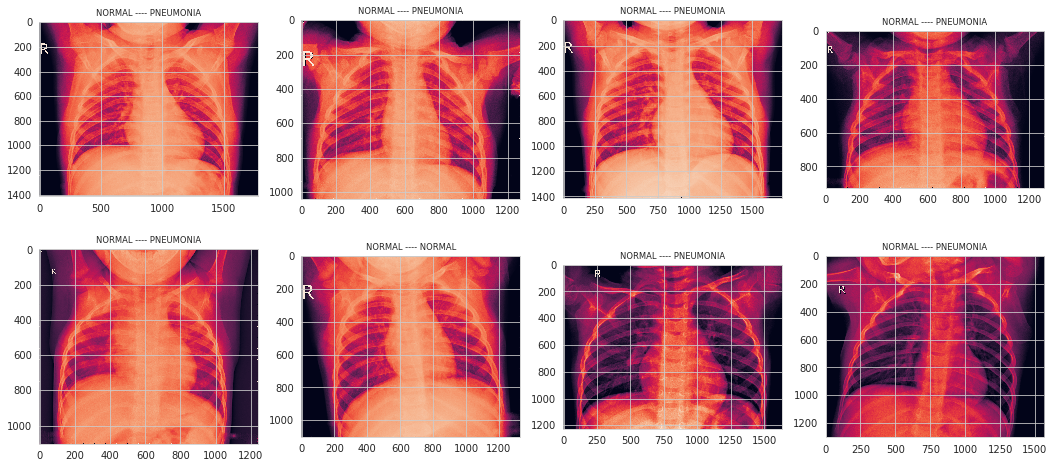

In [143]:
predict_images('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/val/NORMAL', 'NORMAL')

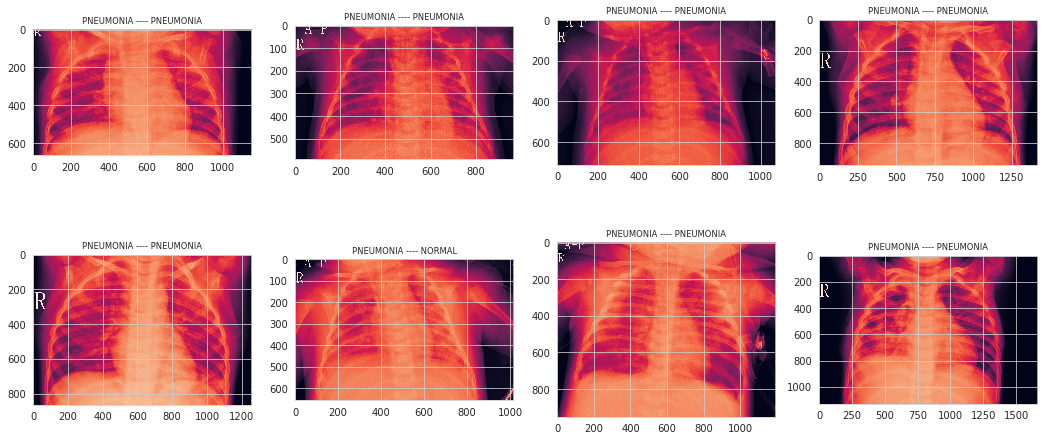

In [144]:
predict_images('/content/drive/My Drive/Final Year Project /Pneumonia Detection /chest_xray/val/PNEUMONIA', 'PNEUMONIA')